**EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

In [36]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [37]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
bp_path = f"{actual_path}/../data/EXP4/BayesPrism/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [38]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
1,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
3,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
4,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
5,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
6,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
7,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [39]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28
1,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
3,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
4,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
5,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
6,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
7,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated polyA:

In [40]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78
1,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
3,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
4,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
5,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
6,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
7,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


Gene maps:

In [6]:
genes_path = os.path.join(data_path, f"gene_maps.csv")
genes_path = Path(genes_path)
genes = pd.read_csv(genes_path, index_col=0)
genes

,Name,Ens
0,MIR1302-2HG,ENSG00000243485
1,FAM138A,ENSG00000237613
2,OR4F5,ENSG00000186092
3,AL627309.1,ENSG00000238009
4,AL627309.3,ENSG00000239945
...,...,...
36596,AC141272.1,ENSG00000277836
36597,AC023491.2,ENSG00000278633
36598,AC007325.1,ENSG00000276017
36599,AC007325.4,ENSG00000278817


In [7]:
#Assigning gene names
gene_ids = genes["Name"]
bulks.columns = genes["Name"]
diss_bulks.columns = genes["Name"]

In [8]:
#matching index 
bulks.index = range(1,9)
diss_bulks.index = range(1,9)
disspolya_bulks.index = range(1,9)
bulks

Name,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
1,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
2,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
3,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
4,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
5,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
6,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
7,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
8,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


And all single-cells:

In [9]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [10]:
#attaching adatas (sc) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

QC imported dataset:

In [11]:
#fcn to extract proportions from each adata and remove cell types that are not frequent
def get_prop_delete_nonfreqcells(adata):
    props = vp.make_prop_table(adata, "cell_types")
    idx_total = props[ (props['Cell_Types'] == 'Total')].index
    props = props.drop(idx_total, inplace=False)
    props = props.sort_values(by='Cell_Types')
    props = props.set_index('Cell_Types')
    print(props)
    return props, adata

In [12]:
#Our ground truth in this case is single cell
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = get_prop_delete_nonfreqcells(adatas[num])

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

In [13]:
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))

Counter({'Plasma cells': 1432, 'T cells': 506, 'Endothelial cells': 503, 'Fibroblasts': 206, 'Macrophages': 123, 'NK cells': 114, 'B cells': 62, 'Epithelial cells': 56, 'Monocytes': 54, 'ILC': 24, 'DC': 13, 'pDC': 9})
Counter({'T cells': 734, 'Epithelial cells': 99, 'NK cells': 67, 'B cells': 41, 'Macrophages': 26, 'Endothelial cells': 18, 'Monocytes': 17, 'Fibroblasts': 13, 'Plasma cells': 13, 'DC': 6, 'pDC': 5})
Counter({'Macrophages': 378, 'Fibroblasts': 236, 'Epithelial cells': 236, 'T cells': 142, 'Monocytes': 49, 'NK cells': 26, 'Endothelial cells': 21})
Counter({'T cells': 3053, 'NK cells': 459, 'Macrophages': 274, 'Epithelial cells': 184, 'Fibroblasts': 98, 'pDC': 96, 'Plasma cells': 94, 'DC': 29, 'Endothelial cells': 21, 'B cells': 18, 'Monocytes': 3})
Counter({'T cells': 720, 'Fibroblasts': 274, 'Endothelial cells': 127, 'Epithelial cells': 118, 'pDC': 60, 'NK cells': 53, 'Monocytes': 38, 'Macrophages': 36, 'B cells': 27, 'ILC': 26, 'Plasma cells': 22, 'DC': 19})
Counter({'T 

In [14]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
adata = sc.concat(adatas_list, join='inner')
adata.var['gene_ids'] = adata.var_names
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

In [15]:
#common genes between adatas and the 
gene_ids = np.intersect1d(bulks.columns, adata.var_names)
bulks = bulks[gene_ids]
diss_bulks = diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]

In [16]:
# Cutting to only genes that are in the bulks:
adata = adata[:, adata.var_names.isin(gene_ids)].copy()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [17]:
# Identify cells with "Unknown 1" and "Unknown 2" cell types
cells_to_remove = (adata.obs['cell_types'] == 'Unknown1') | (adata.obs['cell_types'] == 'Unknown2')

# Invert the boolean mask to keep cells that do not match the specified cell types
adata = adata[~cells_to_remove, :].copy()
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 16771 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [18]:
Counter(adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Erythroid': 21})

In [19]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Mast cells", "Erythroid"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Fibroblasts' 'ILC'
 'Macrophages' 'Monocytes' 'NK cells' 'Plasma cells' 'T cells' 'pDC']


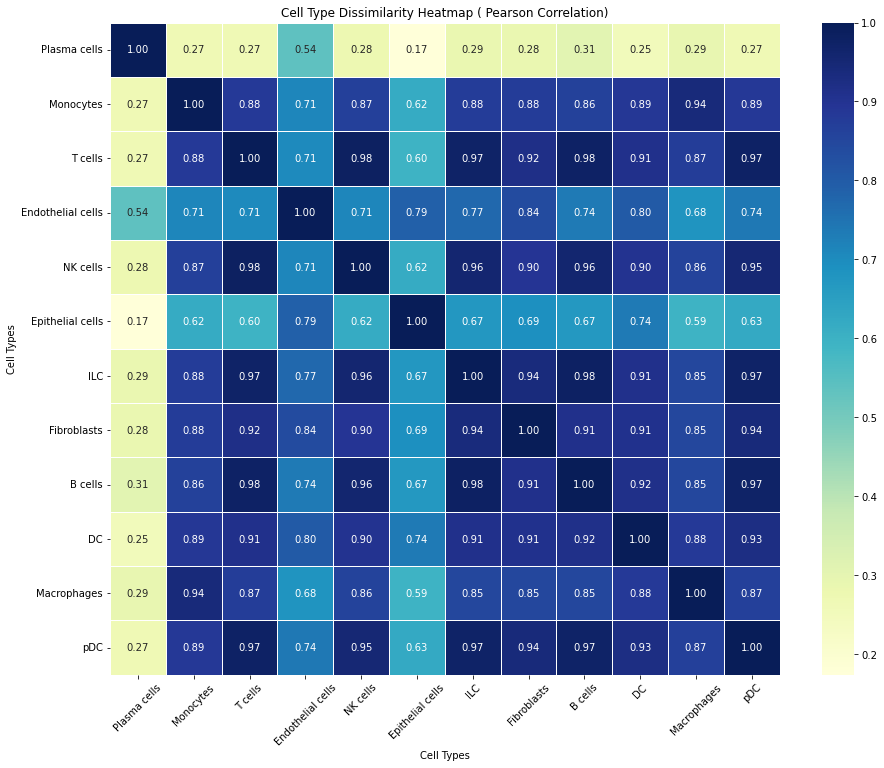

In [20]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = adata.obs["cell_types"].unique()
gene_ids = adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

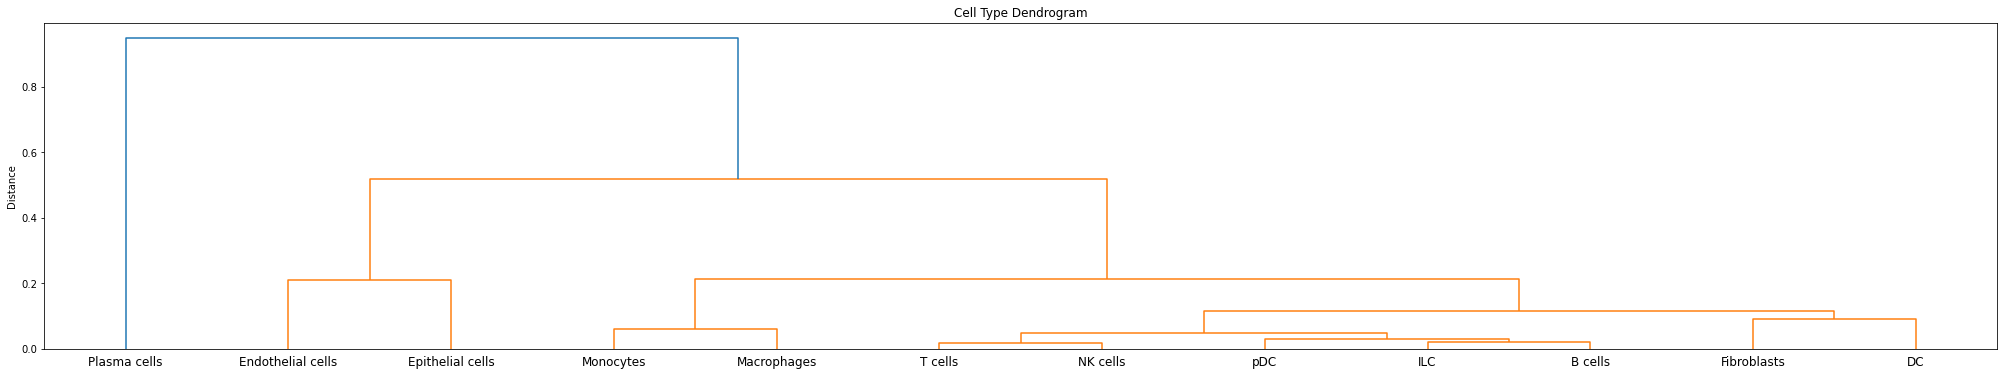

In [21]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [22]:
#check cell types in untransformed data
Counter(adata.obs["cell_types"])

Counter({'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170})

## **Creating Reference**

All Cells Included in Reference,
We need 1 reference, and 3 bulk files for each type of bulk.

Limiting Cell Type number for computation:

In [23]:
# initializing dicitonaries of proportions and cell references.
all_refs = dict()

In [24]:
#with no cell missing is just the anndata object as is
#all cell types included QC
print(Counter(adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = adata.X.todense()
num=0
dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value= adata.obs["cell_types"].to_list())
dense_df.index = dense_df.index +  1
#qc
sig_df_sn = dense_df
print(sig_df_sn.shape)
all_refs[0] = sig_df_sn

Counter({'T cells': 7419, 'Plasma cells': 1983, 'Epithelial cells': 1694, 'Fibroblasts': 1587, 'Endothelial cells': 1189, 'Macrophages': 1116, 'NK cells': 842, 'Monocytes': 272, 'B cells': 264, 'pDC': 170, 'DC': 98, 'ILC': 89})
(16723, 13725)


In [25]:
sc_cell_types = vp.make_prop_table(adata, "cell_types")
sc_cell_types = sc_cell_types.drop(axis=0, index = len(sc_cell_types)-1)
sc_cell_types = sc_cell_types.sort_values('Cell_Types')
sc_cell_types = sc_cell_types.reindex()
sc_cell_types

,Cell_Types,Num_Cells,Prop_Cells
8,B cells,264,0.015787
9,DC,98,0.005860
3,Endothelial cells,1189,0.071100
5,Epithelial cells,1694,0.101298
7,Fibroblasts,1587,0.094899
6,ILC,89,0.005322
10,Macrophages,1116,0.066734
1,Monocytes,272,0.016265
4,NK cells,842,0.050350
0,Plasma cells,1983,0.118579


In [26]:
#to dense matrix and copying into dict entry
dense_matrix = adata.X.todense()
dense_mat = dict()    
cell_states = dict()
cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
dense_mat[num] = dense_matrix.copy()

dense_df = pd.DataFrame(dense_mat[num], columns = adata.var['gene_ids'].index)
dense_df.insert(loc=0, column='cell_types', value= adata.obs["cell_types"].to_list())
dense_df

,cell_types,LINC01409,LINC01128,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,AGRN,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AL354822.1,AC240274.1,AC007325.4
0,Plasma cells,0.0,0.0,0.0,0.0,0.000000,0.692185,0.000000,4.153111,0.000000,...,22.842112,3.460926,15.920260,5.537482,0.0,11.767149,0.0,0.0,0.0,0.0
1,Plasma cells,0.0,0.0,0.0,0.0,0.000000,0.000000,15.649452,15.649452,0.000000,...,31.298904,15.649452,46.948357,0.000000,0.0,46.948357,0.0,0.0,0.0,0.0
2,Monocytes,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,60.539349,2.751789,19.262520,5.503577,0.0,30.269674,0.0,0.0,0.0,0.0
3,T cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,16.108824,3.579739,10.739216,1.789869,0.0,7.159477,0.0,0.0,0.0,0.0
4,Endothelial cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,19.880716,0.000000,...,44.731613,2.485090,32.306164,7.455269,0.0,52.186882,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16718,T cells,0.0,0.0,0.0,0.0,0.000000,0.000000,2.134472,2.134472,0.000000,...,42.689434,2.134472,23.479189,12.806829,0.0,27.748131,0.0,0.0,0.0,0.0
16719,B cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.172911,0.000000,10.086455,8.645533,0.0,17.291065,0.0,0.0,0.0,0.0
16720,T cells,0.0,0.0,0.0,0.0,1.877934,0.000000,0.000000,0.000000,0.000000,...,18.779343,3.755868,15.023474,1.877934,0.0,22.535210,0.0,0.0,0.0,0.0
16721,Epithelial cells,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2.904444,...,13.069997,0.000000,4.356666,0.000000,0.0,1.452222,0.0,0.0,0.0,0.0


In [27]:
#matching proportion in reference (made from SC cells) to SN proportions
new_dense = pd.DataFrame(columns=dense_df.columns)
for cell_type in sc_cell_types["Cell_Types"]:
    idx_in_mat = sc_cell_types[sc_cell_types['Cell_Types'] == str(cell_type)].index[0]
    all_cells_from_type = dense_df[dense_df["cell_types"] == cell_type].index
    size = sc_cell_types['Num_Cells'].loc[idx_in_mat]
    if size > 1000:
        size = 1000
    if all_cells_from_type.shape != (0,):  
        if len(all_cells_from_type) < size:
            rep = True
        else:
            rep = False    
        random_idx = np.random.choice(all_cells_from_type, size=size, replace=rep)
        old_dense = dense_df.loc[random_idx]
        new_dense = pd.concat([new_dense, old_dense])
new_dense

,cell_types,LINC01409,LINC01128,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,AGRN,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AL354822.1,AC240274.1,AC007325.4
1334,B cells,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,2.257336,0.0,...,29.345373,0.000000,11.286682,9.029346,0.000000,22.573364,0.0,0.0,0.0,0.0
2257,B cells,1.340662,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,40.219872,5.362649,34.857220,10.725299,1.340662,28.153910,0.0,0.0,0.0,0.0
15674,B cells,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,45.422783,6.988121,34.940601,6.988121,0.000000,48.916843,0.0,0.0,0.0,0.0
8037,B cells,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,3.698225,0.0,...,7.396450,7.396450,18.491125,3.698225,0.000000,3.698225,0.0,0.0,0.0,0.0
3472,B cells,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,56.662086,5.151099,15.453297,6.868132,0.000000,32.623627,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,pDC,1.390821,0.000000,0.0,0.0,0.0,0.0,0.000000,13.908206,0.0,...,25.034771,4.172462,12.517385,11.126565,0.000000,22.253130,0.0,0.0,0.0,0.0
10519,pDC,1.514693,0.000000,0.0,0.0,0.0,0.0,0.000000,1.514693,0.0,...,42.411392,4.544078,21.205696,12.117540,1.514693,25.749773,0.0,0.0,0.0,0.0
8923,pDC,0.000000,2.116402,0.0,0.0,0.0,0.0,0.000000,4.232804,0.0,...,38.095238,14.814816,12.698413,21.164021,0.000000,27.513227,0.0,0.0,0.0,0.0
6282,pDC,1.062135,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,15.932023,7.434944,27.615507,20.180563,0.000000,10.621348,0.0,0.0,0.0,0.0


In [28]:
dense_df = new_dense.sort_index()
dense_df

,cell_types,LINC01409,LINC01128,LINC00115,FAM41C,NOC2L,PLEKHN1,HES4,ISG15,AGRN,...,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AL354822.1,AC240274.1,AC007325.4
1,Plasma cells,0.0,0.0,0.0,0.0,0.0,0.0,15.649452,15.649452,0.000000,...,31.298904,15.649452,46.948357,0.000000,0.0,46.948357,0.0,0.0,0.0,0.0
2,Monocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,60.539349,2.751789,19.262520,5.503577,0.0,30.269674,0.0,0.0,0.0,0.0
4,Endothelial cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.880716,0.000000,...,44.731613,2.485090,32.306164,7.455269,0.0,52.186882,0.0,0.0,0.0,0.0
5,NK cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.200512,0.000000,...,41.606659,0.000000,22.403585,6.401024,0.0,22.403585,0.0,0.0,0.0,0.0
6,Plasma cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,8.605852,0.000000,51.635113,8.605852,0.0,34.423409,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16716,Endothelial cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,17.730495,0.000000,0.000000,0.000000,0.0,70.921982,0.0,0.0,0.0,0.0
16717,NK cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,115.121346,6.222775,12.445551,0.000000,0.0,9.334164,0.0,0.0,0.0,0.0
16719,B cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,20.172911,0.000000,10.086455,8.645533,0.0,17.291065,0.0,0.0,0.0,0.0
16721,Epithelial cells,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.904444,...,13.069997,0.000000,4.356666,0.000000,0.0,1.452222,0.0,0.0,0.0,0.0


In [29]:
#does not have the cell types from SN
Counter(dense_df["cell_types"])

Counter({'Plasma cells': 1000,
         'Monocytes': 272,
         'Endothelial cells': 1000,
         'NK cells': 842,
         'Epithelial cells': 1000,
         'ILC': 89,
         'Fibroblasts': 1000,
         'B cells': 264,
         'T cells': 1000,
         'DC': 98,
         'Macrophages': 1000,
         'pDC': 170})

In [30]:
#now creating the cell state file
# cell_id, cell_type, cell_subtype and tumor_state
cell_state = pd.DataFrame(columns = cols)
cell_state["cell_type"] = dense_df["cell_types"].to_list()
cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
cell_state["cell_subtype"] = dense_df["cell_types"].to_list()
cell_state["tumor_state"] = 0
#change idx to start at 1 for R
#save
num = 0
cell_states[num] = cell_state
cellstate_path = os.path.join(bp_path, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
cellstate_path = Path(cellstate_path)
cell_states[num].to_csv(cellstate_path, index = False)

#dropping cell types, they're now in cell state
dense_df.pop("cell_types")
#dense_df.to_csv(sc_profile_path, index=True)
all_refs[num] = dense_df
#qc
print(dense_df.shape)
print(cell_state.shape)

(7735, 13724)
(7735, 4)


In [31]:
num = 0
reference = all_refs[num]
reference.index = range(1, len(reference)+1)
#details
num_str = str(num)  
exp_id = str(res_name)

In [32]:
#and create files for each:
#Classic
this_bulk= bulks
bt = "real_classic_rrna"
bulks_mix, sig = sn_sc_preprocess.write_bp_files(bp_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)

#Dissociated_rrna
this_bulk= diss_bulks
bt = "real_dissociated_rrna"
dissbulks_mix, sig = sn_sc_preprocess.write_bp_files(bp_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)
#Dissociated_polyA
this_bulk= disspolya_bulks
bt = "real_dissociated_polya"
disspolyabulks_mix, sig = sn_sc_preprocess.write_bp_files(bp_path, out_file_id = exp_id, 
                                        sig_df = reference,  X_train = this_bulk, num_str = num_str, bulks_type= bt)
                                        

## Creating bulk files:

In [33]:
#and writing the bulk files for each:
#Classic
method = "classic_rrna"
bulk_type = "real"
mix = bulks_mix
sc_profile_file = os.path.join(bp_path, f"{exp_id}_{bulks_type}_{method}_mixture.csv")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids
mix.to_csv(sc_profile_path, index = True)
mix

,0,1,2,3,4,5,6,7
gene_ids,,,,,,,,
LINC01409,135,107,82,29,51,300,27,81
LINC01128,98,101,85,35,47,196,28,87
LINC00115,24716,6238,4221,39378,11374,12922,53177,31569
FAM41C,183,59,60,82,71,91,134,150
NOC2L,256,220,351,983,62,618,410,365
...,...,...,...,...,...,...,...,...
MT-CYB,388,304,361,559,253,251,306,391
MAFIP,1786,2435,1820,944,1583,2067,878,1801
AL354822.1,2614,1305,703,2068,1349,2039,1367,2234


In [34]:
#Dissociated, rrna
method = "dissociated_rrna"
bulk_type = "real"
mix = dissbulks_mix
sc_profile_file = os.path.join(bp_path, f"{exp_id}_{bulks_type}_{method}_mixture.csv")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids
mix.to_csv(sc_profile_path, index = True)
mix

,0,1,2,3,4,5,6,7
gene_ids,,,,,,,,
LINC01409,197,81,186,82,48,152,94,64
LINC01128,55,59,47,40,19,75,64,24
LINC00115,32868,26055,15846,30034,24867,15348,32943,43311
FAM41C,96,64,24,56,128,67,162,76
NOC2L,420,257,363,1154,325,504,344,769
...,...,...,...,...,...,...,...,...
MT-CYB,449,145,639,782,562,404,409,709
MAFIP,1653,1176,2032,1230,1368,1977,1155,1586
AL354822.1,2287,1078,549,1118,1695,1621,1281,1376


In [35]:
#Dissociated, polya
method = "dissociated_polya"
bulk_type = "real"
mix = disspolyabulks_mix
sc_profile_file = os.path.join(bp_path, f"{exp_id}_{bulks_type}_{method}_mixture.csv")
sc_profile_path = Path(sc_profile_file)
mix.index = gene_ids
mix.to_csv(sc_profile_path, index = True)
mix

,0,1,2,3,4,5,6,7
gene_ids,,,,,,,,
LINC01409,303,145,123,83,29,79,69,55
LINC01128,161,87,35,62,21,51,75,25
LINC00115,85559,54188,24366,67865,26932,22454,40836,60905
FAM41C,130,89,29,62,59,58,37,67
NOC2L,941,514,415,1599,390,565,367,892
...,...,...,...,...,...,...,...,...
MT-CYB,1223,203,1187,1974,732,537,641,1289
MAFIP,4076,1893,3023,2007,1253,2273,1254,2133
AL354822.1,3718,1402,539,1526,1188,1532,940,1435
